#Walmart Sales Prediction

One of the leading retail stores in the US, Walmart, would like to predict the sales and demand accurately. There are certain events and holidays which impact sales on each day. There are sales data available for 45 stores of Walmart. The business is facing a challenge due to unforeseen demands and runs out of stock some times, due to a mismatch between demand and availability. An ideal ML algorithm will predict demand accurately and ingest factors like economic conditions including CPI, Unemployment Index, etc.

Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of all, which are the Super Bowl, Labour Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data. Historical sales data for 45 Walmart stores located in different regions are available.

Acknowledgements
The dataset is taken from Kaggle.

Objective:
1. Data Pre-processing
2. Feature selection
3. Build Regression Models [Including Bagging and Boosting]
4. Build Time series Models
5. Model evaluation based on WMAE rather than accuracy to avoid overfitting


In [8]:
import os
import math
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn import tree

In [5]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.3 MB/s eta 0:00:00


In [6]:
pip install numba==0.53

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 36.9 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.1
    Uninstalling llvmlite-0.39.1:
      Successfully uninstalled llvmlite-0.39.1
  Attempting uninstall: numba
    Found existing installation: numba 0.56.4
    Uninstalling numba-0.56.4:
      Successfully uninstalled numba-0.56.4


#Reading Stores, Features and Training CSV Files

Merging the 3 datasets based on Store number and Date

In [130]:
#Reading Stores datafile
pd.options.display.max_columns=100
store = pd.read_csv('stores.csv')
store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [131]:
#Checking null columns
store.isnull().sum()

Store    0
Type     0
Size     0
dtype: int64

In [132]:
#Reading Features CSV
features=pd.read_csv('features.csv')
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [133]:
#Imputing Unemployment and CPI with mean
features_1=features
features_2 = features_1
features_1['CPI'] =features_1['CPI'].fillna(features_1['CPI'].mean())
features_2['Unemployment'] =features_2['Unemployment'].fillna(features_2['Unemployment'].mean())
features_2.info()
features_2.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           8190 non-null   float64
 10  Unemployment  8190 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI                0
Unemployment       0
IsHoliday          0
dtype: int64

In [134]:
#Reading Train file
train_data=pd.read_csv('train.csv')
train_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [135]:
#Merging the three CSVs on "Store" and "Date"
walmart = train_data.merge(features_2, on=['Store', 'Date'], how='inner').merge(store, on=['Store'], how='inner')
walmart.info()
walmart.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday_x   421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  IsHoliday_y   421570 non-null  bool   
 15  Type          421570 non-null  object 
 16  Size          421570 non-null  int64  
dtypes: bool(2), float64(10), int64(3), object(2)
mem

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


#Data-Preprocessing

Getting rid of duplicate columns, converting Date to DateTime, less than 0 weekly sales, categorical values handling, extraction year, month & Week from Date

In [136]:
#Dropping duplicate Holiday column
walmart.drop(['IsHoliday_y'], axis=1,inplace=True)

In [137]:
walmart.rename(columns={"IsHoliday_x" : "IsHoliday"},inplace=True)
walmart.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [138]:
#Changing dtype of Date
walmart["Date"] = pd.to_datetime(walmart["Date"])
walmart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

In [139]:
#Locating weekly sales that are less than or equal to 0. Since this is Walmart and the probability of a department 
#not selling anything the entire week is improbable, I got rid of those rows.
walmart.loc[walmart['Weekly_Sales']<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
188,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
406,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,NaN,NaN,NaN,NaN,NaN,211.827234,7.742,A,151315
4132,1,47,2011-03-11,0.00,False,53.56,3.459,NaN,NaN,NaN,NaN,NaN,214.111056,7.742,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,5370.39,NaN,361.22,1287.62,2461.81,191.002810,8.567,B,118221
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,3291.36,425.60,NaN,314.88,2255.34,191.099246,8.567,B,118221
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,B,118221
421007,45,54,2012-08-31,0.00,False,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,B,118221


In [140]:
#Got rid of rows where weekly_sales <= 0
walmart = walmart.loc[walmart['Weekly_Sales'] >0]
walmart.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,150181.000000,110904.000000,136651.000000,134518.000000,150929.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,60.090599,3.360890,7247.821269,3330.146158,1441.736203,3384.782267,4629.531870,171.212496,7.960000,136749.732787
std,12.787236,30.508819,22729.492116,18.447857,0.458519,8293.028741,9460.395025,9631.968459,6295.136952,5960.171711,39.162445,1.863879,60993.084568
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2120.130000,46.680000,2.933000,2240.270000,41.600000,5.100000,504.220000,1878.440000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7661.700000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20271.265000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.445487,8.567000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


In [141]:
#Changing Holiday value to boolean. Map function wasn't working for some reason
type_group = {True:1, False: 0}
walmart['IsHoliday'] = walmart['IsHoliday'].replace(type_group)

In [142]:
#Changing type of store to boolean. 
type_group_2 = {'A':1, 'B':2, 'C':3}
walmart['Type'] = walmart['Type'].replace(type_group_2)

In [143]:
#Filling markdown columns with 0s. Markdown do not directly reflect Holidays. A little research into past projects
#threw light on the fact that markdowns can happen regardless of holidays, that they are just promotional events
#such as spring clearance sale, summer sale or so on.
walmart=walmart.fillna(0)

In [144]:
# VIF values
X = walmart[['Store','Dept','Weekly_Sales','IsHoliday','Temperature','Fuel_Price',
             'MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment','Type','Size']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
 
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)    


         feature        VIF
0          Store   4.512400
1           Dept   3.150781
2   Weekly_Sales   1.641012
3      IsHoliday   1.238067
4    Temperature  13.591012
5     Fuel_Price  42.252520
6      MarkDown1   4.768807
7      MarkDown2   1.158128
8      MarkDown3   1.099155
9      MarkDown4   3.752995
10     MarkDown5   1.458984
11           CPI  17.196513
12  Unemployment  19.921181
13          Type  16.078313
14          Size  13.850234


#Assigning Holiday markers based on Dates

In [145]:
#Holiday dates
#Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
#Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
#Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
#Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13
#After 7-Sep-2012 are in test dataset

# Super bowl dates in train set
walmart.loc[(walmart['Date'] == '2010-02-12')|(walmart['Date'] == '2011-02-11')|(walmart['Date'] == '2012-02-10'),'Super_Bowl'] = True
walmart.loc[(walmart['Date'] != '2010-02-12')&(walmart['Date'] != '2011-02-11')&(walmart['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [146]:
# Labor day dates in train set
walmart.loc[(walmart['Date'] == '2010-09-10')|(walmart['Date'] == '2011-09-09')|(walmart['Date'] == '2012-09-07'),'Labor_Day'] = True
walmart.loc[(walmart['Date'] != '2010-09-10')&(walmart['Date'] != '2011-09-09')&(walmart['Date'] != '2012-09-07'),'Labor_Day'] = False

In [147]:
# Thanksgiving dates in train set
walmart.loc[(walmart['Date'] == '2010-11-26')|(walmart['Date'] == '2011-11-25'),'Thanksgiving'] = True
walmart.loc[(walmart['Date'] != '2010-11-26')&(walmart['Date'] != '2011-11-25'),'Thanksgiving'] = False


In [148]:
#Christmas dates in train set
walmart.loc[(walmart['Date'] == '2010-12-31')|(walmart['Date'] == '2011-12-30'),'Christmas'] = True
walmart.loc[(walmart['Date'] != '2010-12-31')&(walmart['Date'] != '2011-12-30'),'Christmas'] = False

In [149]:
#Holidays to boolean conversion
type_group_3 = {True:1, False:0,}
walmart['Super_Bowl'] = walmart['Super_Bowl'].replace(type_group_3)

In [150]:
walmart['Labor_Day'] = walmart['Labor_Day'].replace(type_group_3)

In [151]:
walmart['Thanksgiving'] = walmart['Thanksgiving'].replace(type_group_3)

In [152]:
walmart['Christmas'] = walmart['Christmas'].replace(type_group_3)
walmart

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,1,151315,0,0,0,0
1,1,2,2010-02-05,50605.27,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,1,151315,0,0,0,0
2,1,3,2010-02-05,13740.12,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,1,151315,0,0,0,0
3,1,4,2010-02-05,39954.04,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,1,151315,0,0,0,0
4,1,5,2010-02-05,32229.38,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,1,151315,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,0,0,0,0
421566,45,94,2012-10-26,5203.31,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,0,0,0,0
421567,45,95,2012-10-26,56017.47,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,0,0,0,0
421568,45,97,2012-10-26,6817.48,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,0,0,0,0


In [154]:
#Extracting week, year and month from date
walmart["Date"] = pd.to_datetime(walmart["Date"]) # convert to datetime
walmart['week'] =walmart['Date'].dt.week
walmart['month'] =walmart['Date'].dt.month 
walmart['year'] =walmart['Date'].dt.year

<ipython-input-154-105301f56c0f>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  walmart['week'] =walmart['Date'].dt.week


In [34]:
walmart.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1.0,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
1,1,2.0,2010-02-05,50605.27,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
2,1,3.0,2010-02-05,13740.12,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
3,1,4.0,2010-02-05,39954.04,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
4,1,5.0,2010-02-05,32229.38,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010


#Histograms and Heat Map

<Axes: >

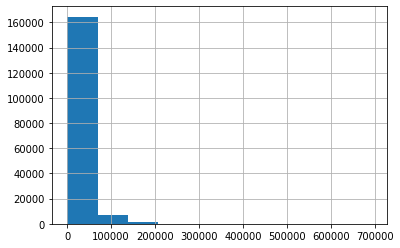

In [35]:
walmart['Weekly_Sales'].hist()

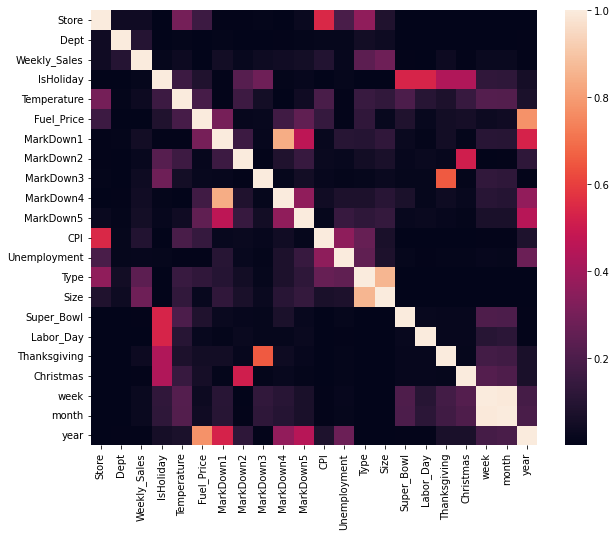

In [36]:
plt.figure(figsize = (10,8))
sns.heatmap(walmart.corr().abs())    # To see the correlations
plt.show()

In [37]:
#Feature selection - 
#markdown 3 highly correlated with thanksgiving.
#Markdown 1 highly correlated with markdown 4
#Size and Type highly correlated
#Fuel-price correlated with year
#Removing Markdown 3, Markdown 4, Size for one model and then type to check if model improves, fuel-price

In [38]:
walmart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172820 entries, 0 to 173323
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         172820 non-null  int64         
 1   Dept          172820 non-null  float64       
 2   Date          172820 non-null  datetime64[ns]
 3   Weekly_Sales  172820 non-null  float64       
 4   IsHoliday     172820 non-null  int64         
 5   Temperature   172820 non-null  float64       
 6   Fuel_Price    172820 non-null  float64       
 7   MarkDown1     172820 non-null  float64       
 8   MarkDown2     172820 non-null  float64       
 9   MarkDown3     172820 non-null  float64       
 10  MarkDown4     172820 non-null  float64       
 11  MarkDown5     172820 non-null  float64       
 12  CPI           172820 non-null  float64       
 13  Unemployment  172820 non-null  float64       
 14  Type          172820 non-null  int64         
 15  Size          172

In [39]:
walmart_og=walmart
walmart_og.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1.0,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
1,1,2.0,2010-02-05,50605.27,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
2,1,3.0,2010-02-05,13740.12,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
3,1,4.0,2010-02-05,39954.04,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
4,1,5.0,2010-02-05,32229.38,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010


In [40]:
walmart=walmart_og
walmart.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1.0,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
1,1,2.0,2010-02-05,50605.27,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
2,1,3.0,2010-02-05,13740.12,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
3,1,4.0,2010-02-05,39954.04,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010
4,1,5.0,2010-02-05,32229.38,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0,5,2,2010


In [41]:
walmart_y=walmart['Weekly_Sales']

In [42]:
walmart=walmart.drop(['MarkDown3','MarkDown4','Size','Fuel_Price','month','Unemployment'],axis=1)

In [43]:
walmart=walmart.drop(['year','Weekly_Sales'],axis=1)

In [44]:
walmart=walmart.drop(['Date'],axis=1)

In [45]:
walmart=walmart.drop(['Super_Bowl','Labor_Day','Christmas'],axis=1)

In [46]:
walmart=walmart.drop(['Temperature'],axis=1)

In [47]:
scaler = RobustScaler()
walmart_rs = scaler.fit_transform(walmart)

In [48]:
walmart.head()

,Store,Dept,IsHoliday,MarkDown1,MarkDown2,MarkDown5,CPI,Type,Thanksgiving,week
0,1,1.0,0,0.0,0.0,0.0,211.096358,1,0,5
1,1,2.0,0,0.0,0.0,0.0,211.096358,1,0,5
2,1,3.0,0,0.0,0.0,0.0,211.096358,1,0,5
3,1,4.0,0,0.0,0.0,0.0,211.096358,1,0,5
4,1,5.0,0,0.0,0.0,0.0,211.096358,1,0,5


In [49]:
walmart_rs = pd.DataFrame(walmart_rs,columns=['Store','Dept','IsHoliday','MarkDown1','MarkDown2','MarkDown5','CPI','Type','Thanksgiving','week'])

In [50]:
#Train features
X_train=walmart_rs
Y_train=walmart_y

In [51]:
# Using Skicit-learn to split data into training and testing sets

X_train, x_test, Y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 42)

In [52]:
Y_train.describe()

count    120974.000000
mean      17395.798025
std       24935.422832
min           0.010000
25%        2639.070000
50%        8279.735000
75%       21293.767500
max      693099.360000
Name: Weekly_Sales, dtype: float64

#Manual WMAE calculation function

In [53]:
#The holidays have a 5times more weighted error than non-holidays. I wrote a function to calculate the error based on
#the formula given by walmart's competition in the question
def wmae_test(test, pred): # WMAE for test 
    weights = x_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

#Random Forest Model

In [54]:
rfr = rf(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                            max_features = 'sqrt',min_samples_split = 10)
#rfr1 = rf(n_estimators=100, random_state=42, n_jobs=-1, max_depth=40,
#                            max_features = 'sqrt',min_samples_split = 8)

In [55]:
# predictions on train set
rfr.fit(X_train,Y_train)
y_pred = rfr.predict(X_train)

In [56]:
# predictions on test set
y_pred_test = rfr.predict(x_test)
rfr_wmae=wmae_test(y_test,y_pred_test)
print(rfr_wmae)

1692.8767697543099


In [57]:
X=walmart_rs

#Feature Importance for Random Forest

Feature ranking:
1. feature 1 (0.712090)
2. feature 7 (0.103365)
3. feature 0 (0.068220)
4. feature 6 (0.062496)
5. feature 9 (0.025808)
6. feature 5 (0.009011)
7. feature 3 (0.008870)
8. feature 4 (0.005735)
9. feature 8 (0.002492)
10. feature 2 (0.001913)


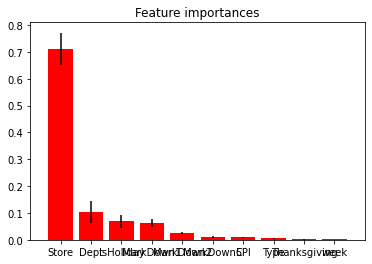

In [58]:
importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), walmart_rs.columns)
plt.xlim([-1, X.shape[1]])
plt.show()

#Linear Regression Model

In [79]:
LR_reg = LinearRegression()
# predictions on train set
LR_reg.fit(X_train,Y_train)
y_pred = LR_reg.predict(X_train)

In [81]:
# predictions on test set
y_pred_test = LR_reg.predict(x_test)
wmae_LinearRegression=wmae_test(y_test,y_pred_test)

In [82]:
wmae_LinearRegression

4607.218105685084

#Decision Trees

In [83]:
DT_reg = DecisionTreeRegressor(max_depth=8,min_samples_leaf=3,random_state=1,max_features=7) 
DT_reg.fit(X_train,Y_train)
y_pred = DT_reg.predict(X_train)

In [84]:
# predictions on test set
y_pred_test = DT_reg.predict(x_test)
wmae_DT=wmae_test(y_test,y_pred_test)
print(wmae_DT)

1980.0060476915394


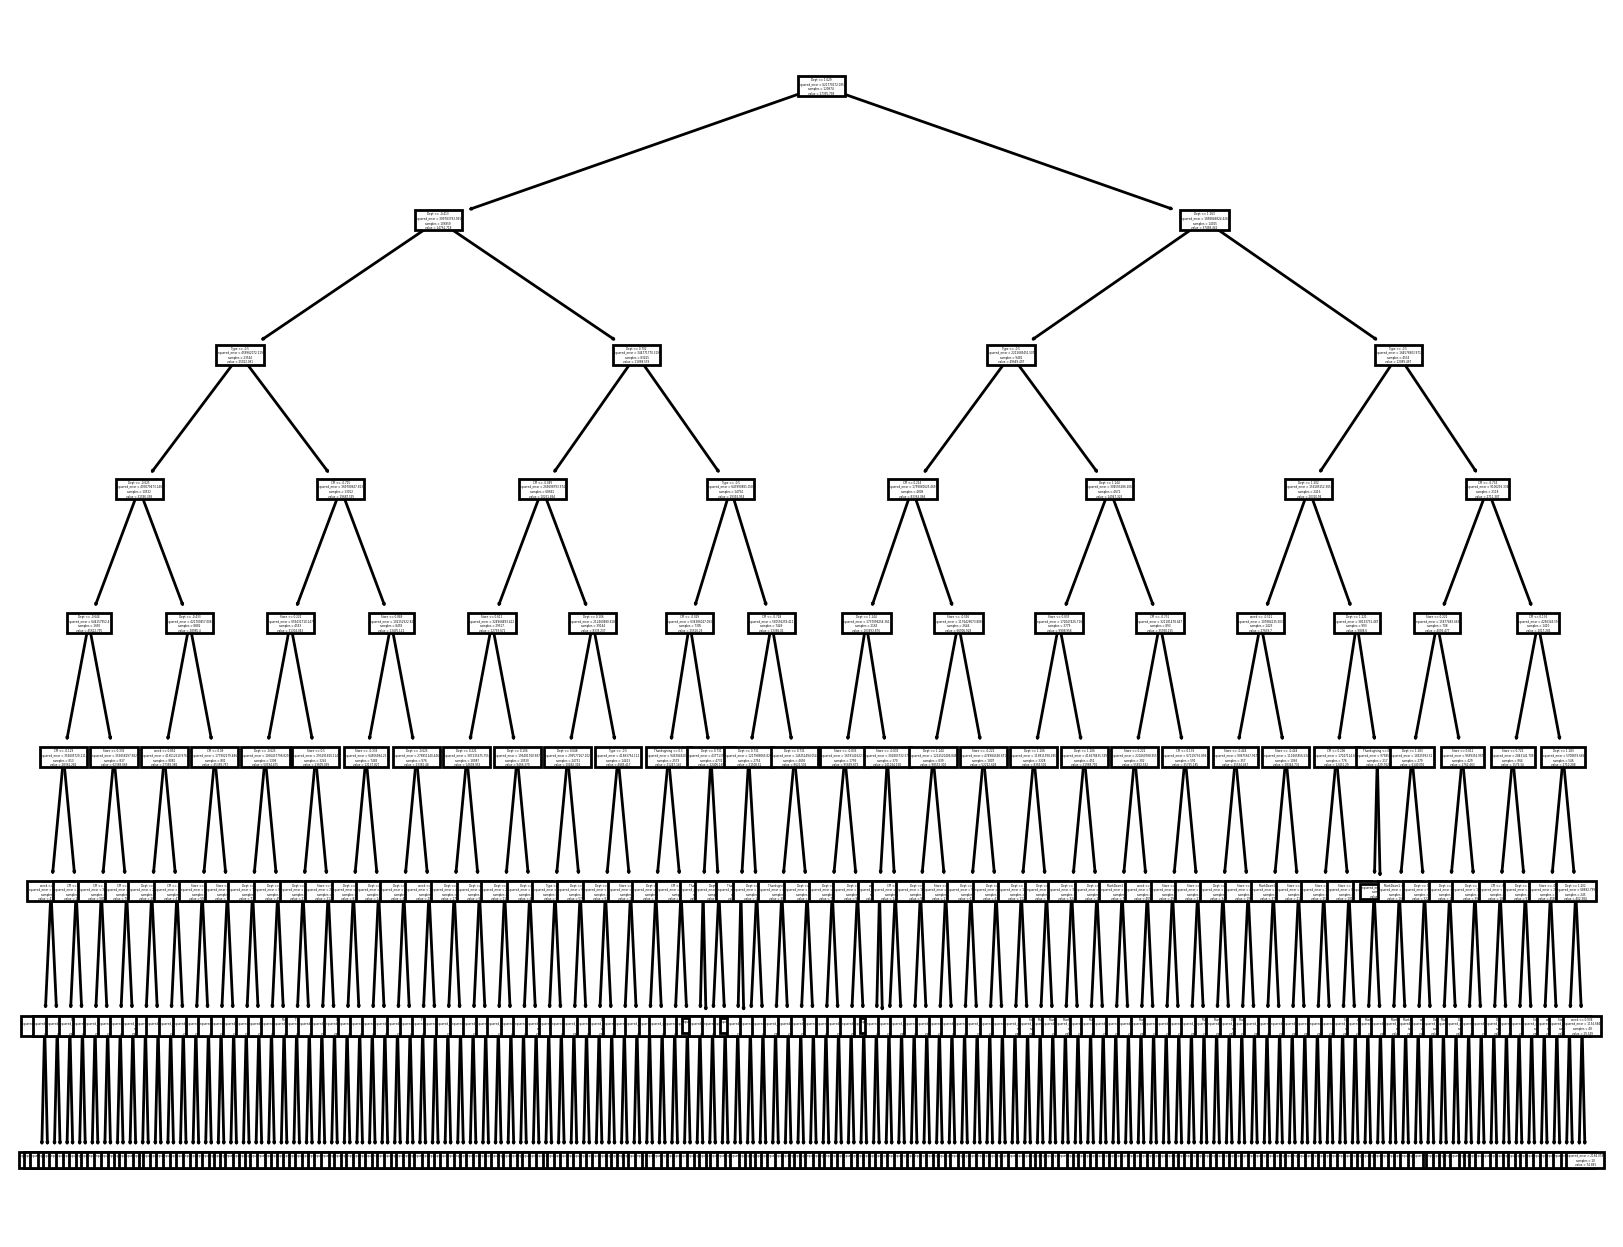

In [85]:
from sklearn.tree import plot_tree
plt.figure(figsize=(10,8), dpi=200)
plot_tree(DT_reg, feature_names=X.columns);

#Ridge Regression

In [86]:
ridge_regr=Ridge(alpha=10)
ridge_regr.fit(X_train, Y_train)
y_pred = ridge_regr.predict(X_train)
y_pred_test = ridge_regr.predict(x_test)
wmae_ridge=wmae_test(y_test,y_pred_test)

#Lasso Regression

In [87]:
lasso_regr=Lasso(alpha=80)
lasso_regr.fit(X_train, Y_train)
y_pred = lasso_regr.predict(X_train)
y_pred_test = lasso_regr.predict(x_test)
wmae_lasso=wmae_test(y_test,y_pred_test)

#XGB Regressor

In [89]:
XGB_regr=XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7)
XGB_regr.fit(X_train, Y_train)
y_pred = XGB_regr.predict(X_train)
y_pred_test = XGB_regr.predict(x_test)
wmae_XGB=wmae_test(y_test,y_pred_test)

In [90]:
wmae_XGB

471.9043862482238

In [91]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': XGB_regr.feature_importances_
}).sort_values('importance', ascending=False)

#Feature Importance for XGB

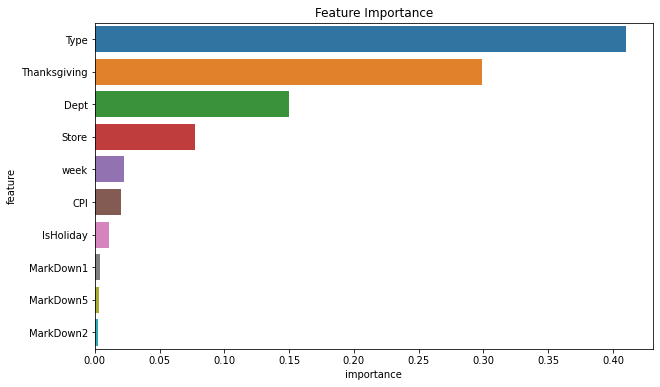

In [92]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

#Extra Trees Regressor

In [96]:
etr = ExtraTreesRegressor(n_estimators=30,n_jobs=4) 
etr.fit(X_train,Y_train)
y_pred=etr.predict(x_test)
wmae_etr=wmae_test(y_test,y_pred)

In [97]:
wmae_etr

542.8978359116633

In [129]:
walmart_og=walmart
walmart.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
1970-01-04,22.195611,44.241309,16033.114591,0.070345,60.090599,3.36089,2590.323565,878.905242,468.845949,1083.534361,1662.805002,171.212496,7.96,1.5895,136749.732787,0.021116,0.021018,0.01415,0.014062,25.828408,6.449866,2010.968454


#Time Series Models - Auto Arima and Exponential Smoothing

In [155]:
walmart['Date'] = pd.to_datetime(walmart['Date'])

In [156]:
walmart.set_index('Date', inplace=True)

<Axes: title={'center': 'Weekly_Sales'}, xlabel='Date'>

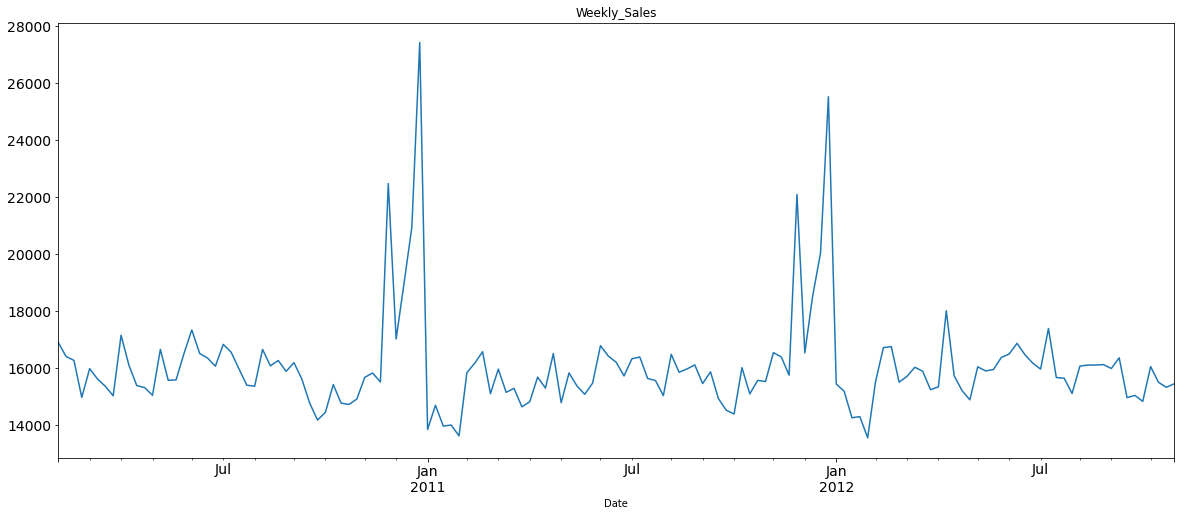

In [157]:
walmart=walmart.resample('W').mean()
walmart['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)

In [158]:
train_data = walmart[:int(0.7*(len(walmart)))] 
test_data = walmart[int(0.7*(len(walmart))):]

In [159]:
target = "Weekly_Sales"
used_cols = [c for c in walmart.columns.to_list() if c not in [target]]

X_train = train_data[used_cols]
x_test = test_data[used_cols]
Y_train = train_data[target]
y_test = test_data[target]

In [160]:
df_week_diff=walmart['Weekly_Sales'].diff().dropna()

In [161]:
train_data_diff = df_week_diff [:int(0.7*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.7*(len(df_week_diff ))):]

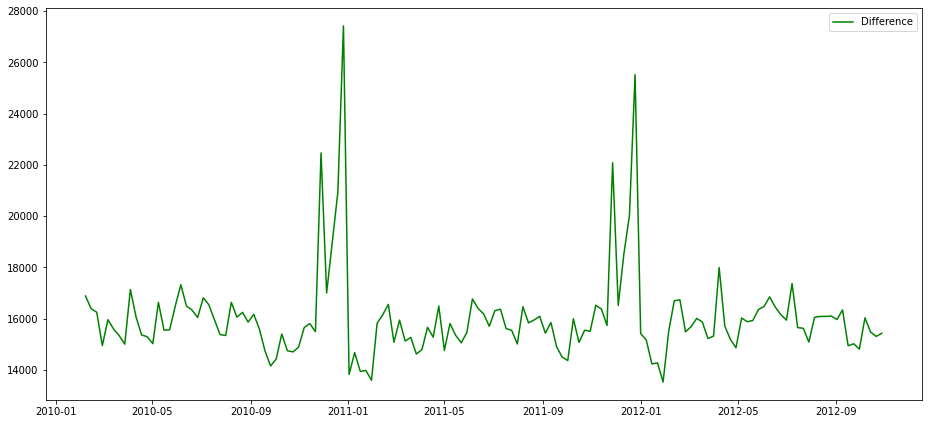

In [162]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(walmart['Weekly_Sales'], color='green',label='Difference')
ax.legend()
fig.tight_layout()

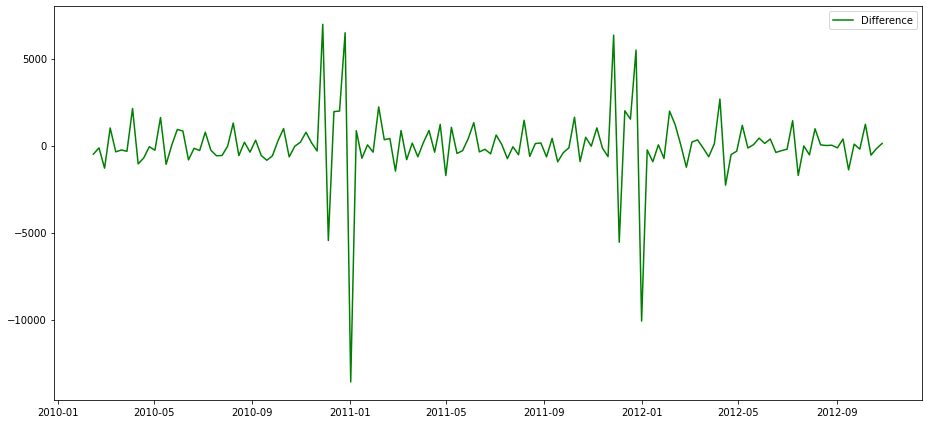

In [163]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='green',label='Difference')
ax.legend()
fig.tight_layout()

In [164]:
adfuller(df_week_diff)

(-6.674883603698557,
 4.491229681533356e-09,
 7,
 134,
 {'1%': -3.480118600110386,
  '5%': -2.8833618426136196,
  '10%': -2.578407034974382},
 2262.9263146472385)

In [165]:
model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1826.858, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1793.619, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1795.532, Time=0.27 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.051, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1794.966, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1801.215, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1791.045, Tim

ARIMA(maxiter=200, order=(3, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

In [ ]:
len(test_data_diff)

43

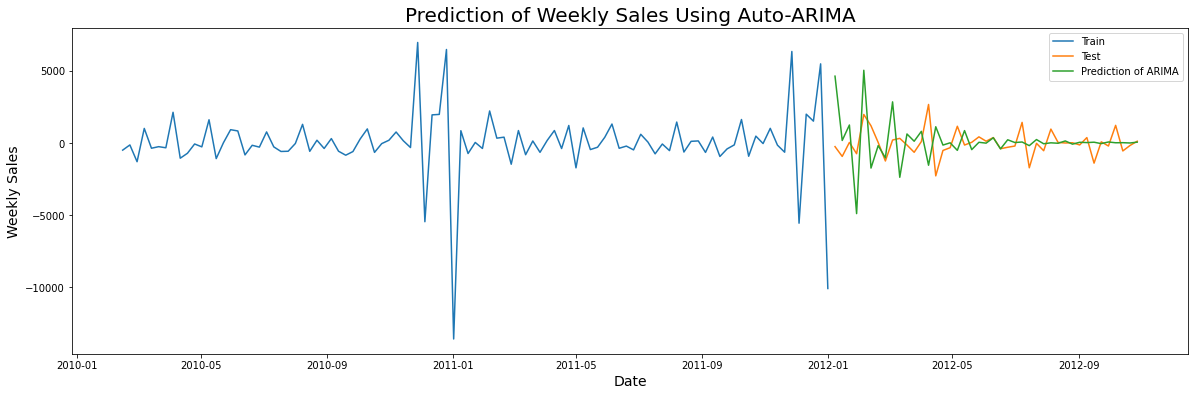

In [172]:
y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [173]:
diff=y_pred['Prediction'] - y_test
wmae_auto_arima=wmae_test(y_pred['Prediction'],y_test)

In [174]:
wmae_auto_arima

15901.573595159973

<ipython-input-178-b0f7562facbf>:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


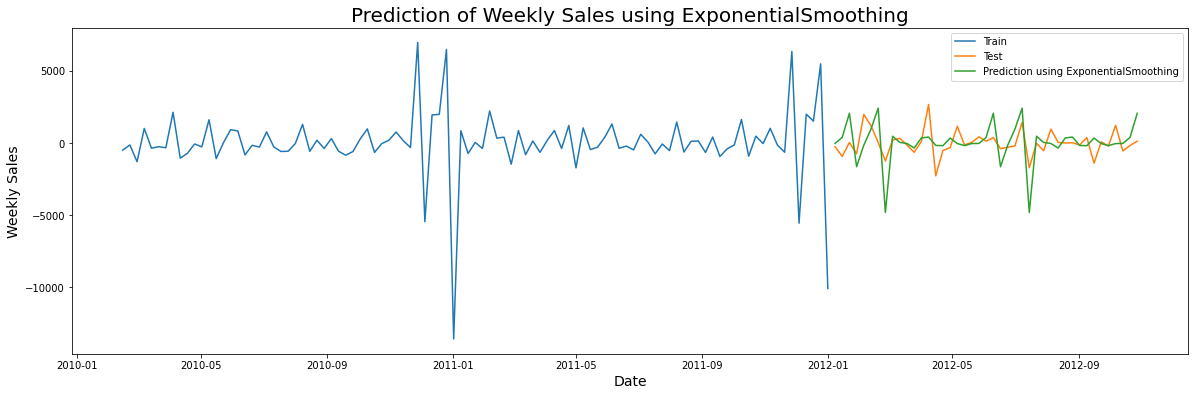

In [178]:
model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() #Taking additive trend and seasonality.
y_pred = model_holt_winters.forecast(len(test_data_diff))# Predict the test data

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [179]:
wmae_exponential_smoothing=wmae_test(test_data_diff, y_pred)

In [180]:
wmae_exponential_smoothing

840.681060966696

In [ ]:
results = pd.DataFrame(columns=['Model','WMAE'])
results=results.append(
    {'Model': 'Auto_Arima Regressor',
     'WMAE' : wmae_auto_arima},ignore_index=True)
results=results.append(
    {'Model': 'Linear Regressor',
     'WMAE' : wmae_LinearRegression},ignore_index=True)
results=results.append(
    {'Model': 'Decision Tree',
     'WMAE' : wmae_DT},ignore_index=True)
results=results.append(
    {'Model': 'Lasso Regression',
     'WMAE' : wmae_lasso},ignore_index=True)
results=results.append(
    {'Model': 'Ridge Regression',
     'WMAE' : wmae_ridge},ignore_index=True)
results=results.append(
    {'Model': 'Random Forest',
     'WMAE' : rfr_wmae},ignore_index=True)
results=results.append(
    {'Model': 'Exponential Smoothing',
     'WMAE' : wmae_exponential_smoothing},ignore_index=True)
results=results.append(
    {'Model': 'Extra Trees Regressor',
     'WMAE' : wmae_etr},ignore_index=True)
results=results.append(
    {'Model': 'XGB Regressor',
     'WMAE' : wmae_XGB},ignore_index=True)



#Final Results

In [192]:
results.sort_values('WMAE',ascending=False)

,Model,WMAE
0,Auto_Arima Regressor,15901.573595
1,Linear Regressor,4607.218106
4,Ridge Regression,4607.194459
3,Lasso Regression,4603.580801
2,Decision Tree,1980.006048
5,Random Forest,1692.876770
6,Exponential Smoothing,840.681061
7,Extra Trees Regressor,542.897836
8,XGB Regressor,471.904386
